In [2]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [3]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [1,3,13]

with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)

D_0_7 = np.random.rand(2,7)

## Load in a Dataset

In [5]:
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


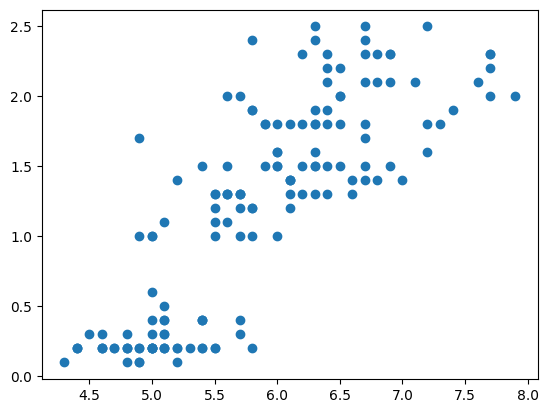

In [12]:
plt.scatter(iris.iloc[:,0], iris.iloc[:,3])

In [13]:
data = iris[['sepal_length', 'petal_width' ]]
data.head()

,sepal_length,petal_width
0,5.1,0.2
1,4.9,0.2
2,4.7,0.2
3,4.6,0.2
4,5.0,0.2


In [34]:
X = pd.DataFrame(data.iloc[:, 0])
## Add a columns of 1s as intercept to X
X['intercept'] = 1
y = data.iloc[:, 1]
m = len(Y)
theta = np.array([0, 0])

In [35]:
iterations = 1500
alpha = 0.01

In [28]:
def cost_function(X, y, theta):
    """
    cost_function(X, y, theta) computes the cost of using theta as the
    parameter for linear regression to fit the data points in X and y
    """
    ## number of training examples
    m = len(y) 
    
    ## Calculate the cost with the given parameters
    J = np.sum((X.dot(theta)-y)**2)/2/m
    
    return J

In [36]:
cost_function(X, y, theta)

1.0077666666666667

In [48]:
cost_history = [0] * iterations
gradient_history = [0] * iterations

for i in range(iterations):
    hypothesis = X.dot(theta)
    loss = hypothesis-y
    gradient = X.T.dot(loss)/m
    theta = theta - alpha*gradient
    cost = cost_function(X, y, theta)

    cost_history[i] = cost
    gradient_history[i] = gradient

In [37]:
def gradient_descent(X, y, theta, alpha, iterations):
    """
    gradient_descent Performs gradient descent to learn theta
    theta = GRADIENTDESENT(X, y, theta, alpha, num_iters) updates theta by 
    taking num_iters gradient steps with learning rate alpha
    """
    cost_history = [0] * iterations
    gradient_history = [0] * iterations
    
    for iteration in range(iterations):
        hypothesis = X.dot(theta)
        loss = hypothesis-y
        gradient = X.T.dot(loss)/m
        theta = theta - alpha*gradient
        cost = cost_function(X, y, theta)
        
        cost_history[iteration] = cost
        gradient_history[iteration] = gradient

    return theta, cost_history, gradient_history

In [38]:
(t, c, g) = gradient_descent(X,y,theta,alpha, iterations)

In [39]:
t

sepal_length    0.344598
intercept      -0.768004
dtype: float64

In [40]:
x_axis = list(range(iterations))

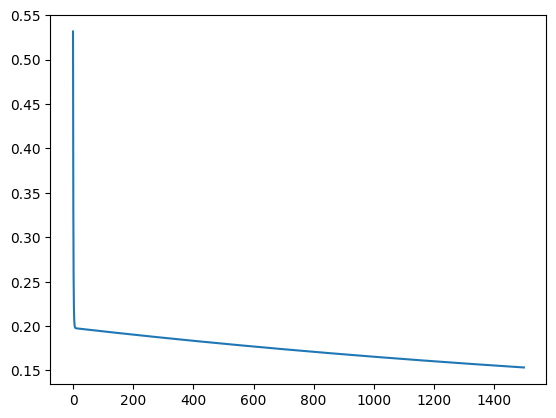

In [45]:
plt.plot(x_axis, c)
plt.show()

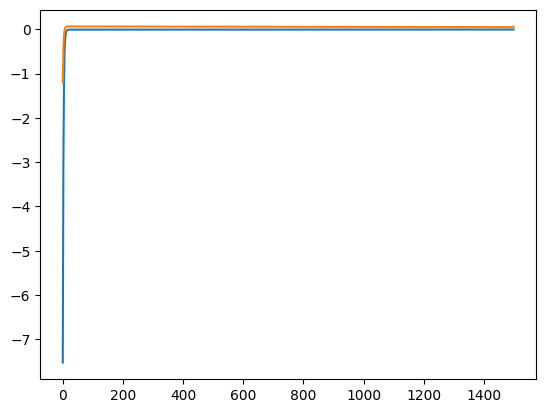

In [44]:
plt.plot(x_axis, g)
plt.show()

In [ ]:
class TrainingMethods:
    # Different training approaches
    
    # This one blows up to NAN/overflow... not sure why
    def train_eta_gradstep(self, w, eta, F, D, H, V, learning_batch, alphaF, alphaD, PCA_comps):
        grad_cost = np.reshape(gradient_cost_l2(F, D, H, V, learning_batch, alphaF, alphaD, Ne=PCA_comps),(2, PCA_comps))
        w_new = w - eta*grad_cost
        return w_new

    def train_eta_scipyminstep(self, w, eta, F, D, H, V, learning_batch, alphaF, alphaD, D0, display_info, PCA_comps, full=False):
        # I turned off display_info because it's kind of annoying
        if full:
            out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps))#, options={'disp': display_info})
        else:
            out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), options={'maxiter':eta}) #'disp': display_info, 
        w_new = np.reshape(out.x,(2, PCA_comps))
        return w_new

In [ ]:
def gd(X, y, theta, alpha, iterations):
    #KAI'S MATRIX VERSION
    """
    gradient_descent Performs gradient descent to learn theta
    theta = GRADIENTDESENT(X, y, theta, alpha, num_iters) updates theta by 
    taking num_iters gradient steps with learning rate alpha
    """
    cost_history = [0] * iterations
    gradient_history = [0] * iterations
    
    for i in range(iterations):
        hypothesis = X@theta
        loss = hypothesis-y
        gradient = X.T@loss/m
        theta = theta - alpha*gradient
        cost = cost_function(X, y, theta)
        cost_history[i] = cost
        gradient_history[i] = gradient

    return theta, cost_history, gradient_history

In [ ]:
print(cond0_training_and_labels_lst[0]['training'].shape)
print(cond0_training_and_labels_lst[0]['training'][update_ix[11]:update_ix[12]].shape)
print(cond0_training_and_labels_lst[0]['labels'][update_ix[11]:update_ix[12]].shape)

In [ ]:
dt = 1.0/60.0

s_temp = cond0_training_and_labels_lst[0]['training'][update_ix[11]:update_ix[12]]
if self.PCA_comps!=self.pca_channel_default:  
    pca = PCA(n_components=self.PCA_comps)
    s_temp = pca.fit_transform(s_temp)
s = np.transpose(s_temp)

v_actual = D@s
p_actual = np.cumsum(v_actual, axis=1)*dt

p_reference = np.transpose(cond0_training_and_labels_lst[0]['labels'][update_ix[11]:update_ix[12]])

F = s[:,:-1]
V = (p_reference - p_actual)*dt

Vglobal = (np.transpose(self.labels[lower_bound:upper_bound,:]) - np.cumsum(self.global_w@s, axis=1)*self.dt)*self.dt
Vlocal = (np.transpose(self.labels[lower_bound:upper_bound,:]) - np.cumsum(self.local_w@s, axis=1)*self.dt)*self.dt

In [ ]:
t = self.current_global_round
eigvals, _ = np.linalg.eig(hessian_cost_l2(self.F, self.alphaD))
mu = np.amin(eigvals)  # Mu is the minimum eigvalue
if mu.imag < self.tol and mu.real < self.tol:
    mu = self.alphaD
elif mu.imag < self.tol:
    mu = mu.real
elif mu.real < self.tol:
    print("Setting to imaginary only")
    mu = mu.imag
L = np.amax(eigvals)  # L is the maximum eigvalue
if L.imag < self.tol and L.real < self.tol:
    raise ValueError("L is 0, thus implying func is not L-smooth")
elif mu.imag < self.tol:
    L = L.real
elif L.real < self.tol:
    print("Setting to imaginary only")
    L = L.imag
if self.verbose:
    print(f"ID: {self.ID}, L: {L}, mu: {mu}")
kappa = L/mu
a = np.max([128*kappa, self.tau])
eta_t = 16 / (mu*(t+a))
if self.input_eta:
    if self.safe_lr!=False:
        raise ValueError("Cannot input eta AND use safe learning rate (they overwrite each other)")
    eta_t = self.eta
elif self.safe_lr!=False:
    eta_t = 1/(self.safe_lr*L)
elif eta_t >= 1/(2*L):
    raise ValueError("Learning rate is too large according to constaints on GD")
if self.verbose:
    print(f"ID: {self.ID}, eta_t: {eta_t}")
    print()
self.p.append((t+a)**2)

if self.adaptive:
    self.adap_alpha.append(self.adap_alpha[-1] - eta_t*np.inner(np.reshape((self.local_w-self.global_w), (self.PCA_comps*2)), np.reshape(gradient_cost_l2(self.F, self.mixed_w, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps), (2*self.PCA_comps,))))

# GRADIENT DESCENT BASED MODEL UPDATE
# NOTE: eta_t IS DIFFERENT FROM CLIENT'S ETA (WHICH IS NOT USED)
# I think the grads really ought to be reshaping this automatically, not sure why it's not

global_gradient = np.reshape(gradient_cost_l2(self.F, self.global_w, self.H, self.Vglobal, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps), (2, self.PCA_comps))
local_gradient = np.reshape(gradient_cost_l2(self.F, self.mixed_w, self.H, self.Vlocal, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps), (2, self.PCA_comps))
# Gradient clipping
if self.gradient_clipping:
    if np.linalg.norm(global_gradient) > self.clipping_threshold:
        global_gradient = self.clipping_threshold*global_gradient/np.linalg.norm(global_gradient)
    if np.linalg.norm(local_gradient) > self.clipping_threshold:
        local_gradient = self.clipping_threshold*local_gradient/np.linalg.norm(local_gradient)

########################################
# Or should I normalize the dec here?  I'll also turn this on since idc about computational speed rn
#if self.normalize_dec:
#    self.global_w /= np.amax(self.global_w)
#    self.local_w /= np.amax(self.local_w)
#    self.mixed_w /= np.amax(self.mixed_w)
########################################

# PSEUDOCODE: my_client.global_w -= my_client.eta * grad(f_i(my_client.global_w; my_client.smallChi))
self.global_w -= eta_t * global_gradient
# PSEUDOCODE: my_client.local_w -= my_client.eta * grad_v(f_i(my_client.v_bar; my_client.smallChi))
self.local_w -= eta_t * local_gradient
self.mixed_w = self.adap_alpha[-1]*self.local_w - (1 - self.adap_alpha[-1])*self.global_w
########################################
# Or should I normalize the dec here?  I'll also turn this on since idc about computational speed rn
#if self.normalize_dec:
#    self.global_w /= np.amax(self.global_w)
#    self.local_w /= np.amax(self.local_w)
#    self.mixed_w /= np.amax(self.mixed_w)
########################################


In [ ]:
def cost_l2(F, D, H, V, learning_batch, alphaF, alphaD, alphaE=1e-6, Nd=2, Ne=64):
    Nt = learning_batch
    D = np.reshape(D,(Nd,Ne))
    Vplus = V[:,1:]
    Vminus = V[:,:-1]
    term1 = alphaE*(np.linalg.norm((D@F + H@Vminus - Vplus))**2)
    term2 = alphaD*(np.linalg.norm(D)**2)
    term3 = alphaF*(np.linalg.norm(F)**2)
    return (term1 + term2 + term3)
# This is the Error function used to compute the loss for SGD
def E(a,b,data):
    # E(a,b) = (y - (a*x +b))^2 
    x,y = data # x and y coordinates of the point
    return (y-(a*x+b))**2

In [ ]:
# This is the gradient of the Error function used to update the equation's coefficients (a and b) for SGD
def gradientE(a,b,data):
    # gradA = dE(a,b)/da = -2*x*(y-a*x+b)
    # gradB = dE(a,b)/db = -2*(y-a*x+b)
    x,y = data
    gradientA = -2*x*(y-(a*x+b))
    gradientB = -2*(y-(a*x+b))

    return np.array([gradientA,gradientB])
def gradient_cost_l2(F, D, H, V, learning_batch, alphaF, alphaD, alphaE=1e-6, Nd=2, Ne=64):
    Nt = learning_batch
    D = np.reshape(D,(Nd, Ne))
    Vplus = V[:,1:]
    Vminus = V[:,:-1]
    return ((2*(D@F + H@Vminus - Vplus)@F.T*(alphaE) + 2*alphaD*D ).flatten())

In [ ]:
# This is the stochastic gradient descent algorithm
def stochasticGradientDescent(E, gradientE, data, startingCoefficients, learningRate, nbIteration):
    
    coefHistory = [] # Used to save the value of a and b at each iteration
    lossHistory = [] # Used to save the value of the loss at each iteration
    gradientHistory = [] # Used to save the value of the gradient at each iteration
    X = startingCoefficients # This is a tuple (a,b) with a and b the starting coefficients
    
    for _ in range((int)(nbIteration/len(data))): # nbIterations/len(data) = number of epochs
        
        for i in range(len(data)): # len(data) iterations are made here
            
            loss = E(*X,data[i]) # Compute the loss for one data and the coefficients a and b
            grad = gradientE(*X,data[i]) # Compute the gradient for one data

            # Save the coefficients, loss and gradient of the current data in the lists
            coefHistory.append(X)
            lossHistory.append(loss)
            gradientHistory.append(grad)

            X = X-learningRate*grad # Update the coefficients a and b 
        
    return coefHistory, lossHistory, gradientHistory


# This is mini-batch stochastic gradient descent algorithm
def miniBatchSGD(E, gradientE, data, startingCoefficients, learningRate, nbEpoch, batchSize):
    
    coefHistory = [] # Used to save the value of a and b at each iteration
    lossHistory = [] # Used to save the value of the loss at each iteration
    gradientHistory = [] # Used to save the value of the gradient at each iteration
    X = startingCoefficients # This is a tuple (a,b) with a and b the starting coefficients
    
    for _ in range(nbEpoch): 
        
        for i in range((int)(np.ceil(len(data)/batchSize))): # Number of steps (iterations)
            batchData = data[i*batchSize:i*batchSize+batchSize] #Create the sublist that contains batchSize data       
            
            loss = MSE(*X,batchData) # Compute the loss thanks to the data and the coefficients a and b
            grad = gradientMSE(*X,batchData) # Compute the gradient 

            # Save the coefficients, loss and gradient of the current iteration (epoch) in the lists
            coefHistory.append(X)
            lossHistory.append(loss)
            gradientHistory.append(grad)

            X = X-learningRate*grad # Update the coefficients a and b 
        
    return coefHistory, lossHistory, gradientHistory

In [ ]:
def condensed_external_plotting(input_data, version, exclusion_ID_lst=[], dim_reduc_factor=10, plot_gradient=False, global_error=True, local_error=True, pers_error=False, different_local_round_thresh_per_client=False, legend_on=False, plot_performance=False, plot_Dnorm=False, plot_Fnorm=False, num_participants=14, show_update_change=False, custom_title="", ylim=-1):
    id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
    
    global_alpha = 0.25
    global_linewidth = 3.5
    local_linewidth = 0.5
    pers_linewidth = 1
    
    def moving_average(numbers, window_size):
        i = 0
        moving_averages = []
        while i < len(numbers) - window_size + 1:
            this_window = numbers[i : i + window_size]

            window_average = sum(this_window) / window_size
            moving_averages.append(window_average)
            i += window_size
        return moving_averages
    
    if custom_title:
        my_title = custom_title
    elif global_error and local_error:
        my_title = f'Global and Local Costs Per {version.title()} Iter'
    elif global_error:
        my_title = f'Global Cost Per {version.title()} Iter'
    elif local_error:
        my_title = f'Local Costs Per {version.title()} Iter'
    else:
        raise ValueError("You set both global and local to False.  At least one must be true in order to plot something.")

    # Determine if this is global or local, based on the input for now... could probably add a flag but meh
    if version.upper()=='LOCAL':
        user_database = input_data
    elif version.upper()=='GLOBAL':
        user_database = input_data.all_clients
    else:
        raise ValueError("log_type must be either global or local, please retry")
        
    running_max = 0
    for i in range(len(user_database)):
        # Skip over users that distort the scale
        if user_database[i].ID in exclusion_ID_lst:
            continue 
        else: 
            # This is used for plotting later
            if len(user_database[i].local_error_log) > running_max:
                running_max = len(user_database[i].local_error_log)

            if version.upper()=='LOCAL':
                if global_error:
                    df = pd.DataFrame(user_database[i].global_error_log)
                    # Need to append a col of indices for the dim reduc... just reset index?
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[1:, 0], df10.values[1:, 1], color=id2color[user_database[i].ID], linewidth=global_linewidth, alpha=global_alpha)
                if local_error:
                    df = pd.DataFrame(user_database[i].local_error_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[1:, 0], df10.values[1:, 1], color=id2color[user_database[i].ID], linewidth=local_linewidth)
                if pers_error:
                    df = pd.DataFrame(user_database[i].personalized_error_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[1:, 0], df10.values[1:, 1], color=id2color[user_database[i].ID], linewidth=pers_linewidth, linestyle="--")
                # NOT THE COST FUNC, THESE ARE THE INDIVIDUAL COMPONENTS OF IT
                if plot_performance:
                    df = pd.DataFrame(user_database[i].performance_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[1:, 0], df10.values[1:, 1], color=id2color[user_database[i].ID], linewidth=pers_linewidth, label=f"User{user_database[i].ID} Performance")
                if plot_gradient:
                    df = pd.DataFrame(user_database[i].gradient_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[1:, 0], df10.values[1:, 1], color=id2color[user_database[i].ID], linewidth=2, label=f"User{user_database[i].ID} Gradient")
            elif version.upper()=='GLOBAL':
                if plot_Fnorm or plot_Dnorm or plot_performance:
                    print("Fnorm, Dnorm, and performance are currently not supported for version==GLOBAL")
                    
                if global_error:
                    client_loss = []
                    client_global_round = []
                    for j in range(input_data.current_round):
                        client_loss.append(input_data.global_error_log[j][i][2])
                        # This is actually the client local round
                        client_global_round.append(input_data.global_error_log[j][i][1])
                    # Why is the [1:] here?  What happens when dim_reduc=1? 
                    # Verify that this is the same as my envelope code...
                    plt.plot(moving_average(client_global_round, dim_reduc_factor)[1:], moving_average(client_loss, dim_reduc_factor)[1:], color=id2color[user_database[i].ID], linewidth=global_linewidth, alpha=global_alpha)

                if local_error:
                    client_loss = []
                    client_global_round = []
                    for j in range(input_data.current_round):
                        client_loss.append(input_data.local_error_log[j][i][2])
                        client_global_round.append(input_data.local_error_log[j][i][1])
                    plt.plot(moving_average(client_global_round, dim_reduc_factor)[1:], moving_average(client_loss, dim_reduc_factor)[1:], color=id2color[user_database[i].ID], linewidth=local_linewidth)
               
                if pers_error:
                    client_loss = []
                    client_global_round = []
                    for j in range(input_data.current_round):
                        client_loss.append(input_data.personalized_error_log[j][i][2])
                        client_global_round.append(input_data.personalized_error_log[j][i][1])
                    plt.plot(moving_average(client_global_round, dim_reduc_factor)[1:], moving_average(client_loss, dim_reduc_factor)[1:], color=id2color[user_database[i].ID], linewidth=pers_linewidth, linestyle="--")

                if show_update_change:
                    for update_round in user_database[i].update_transition_log:
                        plt.axvline(x=(update_round), color=id2color[user_database[i].ID], linewidth=0.5, alpha=0.6)  

    plt.ylabel('Cost L2')
    plt.xlabel('Iteration Number')
    plt.title(my_title)
    if version.upper()=='GLOBAL':
        running_max = input_data.current_round
    num_ticks = 5
    plt.xticks(ticks=np.linspace(0,running_max,num_ticks,dtype=int))
    plt.xlim((0,running_max+1))
    if ylim!=-1:
        plt.ylim((0,ylim))
    if legend_on:
        plt.legend()
    plt.show()

In [ ]:
user_c0_APFL_eta_m10 = [Client(i, D_0_7, 'NAN', cond0_training_and_labels_lst[i], 
                       'streaming', eta=1e-10, input_eta=True, gradient_clipping=True, adaptive=False, 
                       num_steps=10, global_method='APFL') for i in range(14)]

In [ ]:
gradient_descent(X, y, theta, alpha, iterations)

In [ ]:
stochasticGradientDescent(E, gradientE, data, startingCoefficients, learningRate, nbIteration)

In [ ]:
miniBatchSGD(E, gradientE, data, startingCoefficients, learningRate, nbEpoch, batchSize)